# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [38]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [39]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [41]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [42]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [43]:
model = ConvNet()
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

### Optimizer

In [44]:
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [45]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        log_probs = F.log_softmax(input, dim=1)
        probs = torch.exp(log_probs)
        loss = - (torch.pow(1 - probs, self.gamma)) * log_probs
        loss = torch.sum(loss, dim=1)
        return torch.mean(loss)

In [46]:
##################### Write your answer here ##################
# Define the loss function
criterion =nn.CrossEntropyLoss()
#criterion = nn.L1Loss()
#criterion =FocalLoss (gamma=0.5)
#criterion =FocalLoss (gamma=2)
###############################################################

In [47]:
def train_batch(model, image, target):

    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################

    #target = target.view(-1, 1) --when loss function is Li loss
    output = model(image)
    loss = criterion(output,target)
    
    ###############################################################
    return output, loss

In [48]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################

   #target = target.view(-1, 1) --when loss function is Li loss
    output = model(image)
    loss = criterion(output,target)
    
    ###############################################################

    return output, loss

### Model Training

In [12]:
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for epoch in range(NUM_EPOCHS):
    model.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0

    for batch_idx, (image, target) in enumerate(train_dataloader):

        image = image.to(device)
        target = target.to(device)
    
        # train model
    
        outputs, loss = train_batch(model, image, target)  #真实的
        
        _, preds = torch.max(outputs, 1)
        
        #预测的
        
        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)
      

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
 
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)

    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    training_loss.append(epoch_loss)
    training_acc.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        model.eval()
    
        val_loss = 0.0
        val_corrects = 0

        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)

        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        testing_loss.append(val_loss)
        testing_acc.append(val_acc.cpu().detach().numpy())

        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))
    

Epoch: 1/30 Train Loss: 0.0150 Acc: 0.2886
Begin test......
Test Loss: 0.0135 Acc: 0.3626
Epoch: 2/30 Train Loss: 0.0139 Acc: 0.3438
Begin test......
Test Loss: 0.0134 Acc: 0.3697
Epoch: 3/30 Train Loss: 0.0135 Acc: 0.3649
Begin test......
Test Loss: 0.0128 Acc: 0.4101
Epoch: 4/30 Train Loss: 0.0134 Acc: 0.3709
Begin test......
Test Loss: 0.0136 Acc: 0.3811
Epoch: 5/30 Train Loss: 0.0134 Acc: 0.3703
Begin test......
Test Loss: 0.0130 Acc: 0.4022
Epoch: 6/30 Train Loss: 0.0125 Acc: 0.4160
Begin test......
Test Loss: 0.0122 Acc: 0.4372
Epoch: 7/30 Train Loss: 0.0123 Acc: 0.4286
Begin test......
Test Loss: 0.0117 Acc: 0.4624
Epoch: 8/30 Train Loss: 0.0122 Acc: 0.4300
Begin test......
Test Loss: 0.0120 Acc: 0.4519
Epoch: 9/30 Train Loss: 0.0122 Acc: 0.4314
Begin test......
Test Loss: 0.0116 Acc: 0.4703
Epoch: 10/30 Train Loss: 0.0121 Acc: 0.4388
Begin test......
Test Loss: 0.0118 Acc: 0.4689
Epoch: 11/30 Train Loss: 0.0115 Acc: 0.4655
Begin test......
Test Loss: 0.0109 Acc: 0.5060
Epoch: 1

In [13]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# 将target和preds转换为numpy数组
target_np = target.cpu().numpy()
preds_np = preds.cpu().numpy()

# 计算混淆矩阵
conf_matrix = confusion_matrix(target_np, preds_np)

# 计算准确度
accuracy = accuracy_score(target_np, preds_np)

# 计算精确度
precision = precision_score(target_np, preds_np, average='weighted')

# 计算召回率
recall = recall_score(target_np, preds_np, average='weighted')

# 计算F1分数
f1 = f1_score(target_np, preds_np, average='weighted')

print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Confusion Matrix:
[[0 0 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 2 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 2 0 0]
 [0 0 0 0 0 1 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0]]
Accuracy: 0.375
Precision: 0.31875
Recall: 0.375
F1 Score: 0.34151785714285715


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


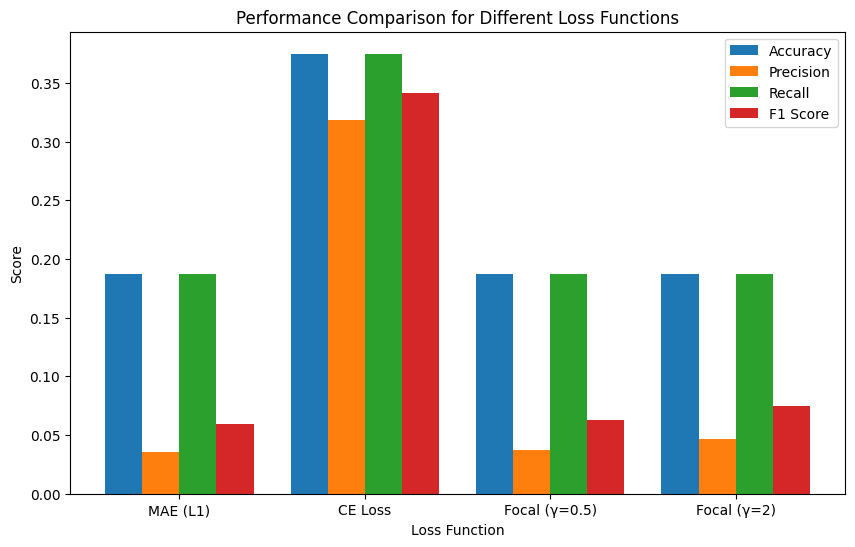

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
accuracy_ce= 0.375 
precision_ce= 0.31875
recall_ce= 0.375
f1_ce= 0.34151785714285715

accuracy_mae= 0.1875
precision_mae= 0.03515625
recall_mae= 0.1875
f1_mae= 0.05921052631578947

accuracy_focal_05= 0.1875
precision_focal_05= 0.037500000000000006
recall_focal_05= 0.1875
f1_focal_05= 0.0625

accuracy_focal_2= 0.1875
precision_focal_2= 0.046875
recall_focal_2= 0.1875
f1_focal_2= 0.07500000000000001
# 准备数据
loss_functions = ['MAE (L1)', 'CE Loss', 'Focal (γ=0.5)', 'Focal (γ=2)']
accuracy_scores = [accuracy_mae, accuracy_ce, accuracy_focal_05, accuracy_focal_2]
precision_scores = [precision_mae, precision_ce, precision_focal_05, precision_focal_2]
recall_scores = [recall_mae, recall_ce, recall_focal_05, recall_focal_2]
f1_scores = [f1_mae, f1_ce, f1_focal_05, f1_focal_2]

# 创建子图
fig, ax = plt.subplots(figsize=(10, 6))

# 设置x轴位置
x = np.arange(len(loss_functions))

# 绘制条形图
bar_width = 0.2
plt.bar(x, accuracy_scores, width=bar_width, label='Accuracy')
plt.bar(x + bar_width, precision_scores, width=bar_width, label='Precision')
plt.bar(x + 2*bar_width, recall_scores, width=bar_width, label='Recall')
plt.bar(x + 3*bar_width, f1_scores, width=bar_width, label='F1 Score')

# 添加标签
plt.xlabel('Loss Function')
plt.ylabel('Score')
plt.title('Performance Comparison for Different Loss Functions')
plt.xticks(x + 1.5*bar_width, loss_functions)
plt.legend()

# 显示图形
plt.show()


In [50]:
import matplotlib.pyplot as plt
import pandas as pd
accuracy_ce= 0.375 
precision_ce= 0.31875
recall_ce= 0.375
f1_ce= 0.34151785714285715

accuracy_mae= 0.1875
precision_mae= 0.03515625
recall_mae= 0.1875
f1_mae= 0.05921052631578947

accuracy_focal_05= 0.1875
precision_focal_05= 0.037500000000000006
recall_focal_05= 0.1875
f1_focal_05= 0.0625

accuracy_focal_2= 0.1875
precision_focal_2= 0.046875
recall_focal_2= 0.1875
f1_focal_2= 0.07500000000000001
# 准备数据
data = {'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'MAE (L1)': [accuracy_mae, precision_mae, recall_mae, f1_mae],
        'CE Loss': [accuracy_ce, precision_ce, recall_ce, f1_ce],
        'Focal (γ=0.5)': [accuracy_focal_05, precision_focal_05, recall_focal_05, f1_focal_05],
        'Focal (γ=2)': [accuracy_focal_2, precision_focal_2, recall_focal_2, f1_focal_2]}

# 创建数据框
df_metrics = pd.DataFrame(data)

# 显示分类指标表格
print("Classification Metrics:")
print(df_metrics)

## 混淆矩阵的示例数据（需要替换成实际的混淆矩阵）
#conf_matrix_data = [[100, 10, 5],
                    #[5, 200, 3],
                    #[2, 8, 150]]

# 创建混淆矩阵数据框
#df_conf_matrix = pd.DataFrame(conf_matrix_data, columns=['Class 0', 'Class 1', 'Class 2'], index=['Predicted 0', 'Predicted 1', 'Predicted 2'])

# 显示混淆矩阵
#print("\nConfusion Matrix:")
#print(df_conf_matrix)


Classification Metrics:
      Metric  MAE (L1)   CE Loss  Focal (γ=0.5)  Focal (γ=2)
0   Accuracy  0.187500  0.375000         0.1875     0.187500
1  Precision  0.035156  0.318750         0.0375     0.046875
2     Recall  0.187500  0.375000         0.1875     0.187500
3   F1 Score  0.059211  0.341518         0.0625     0.075000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


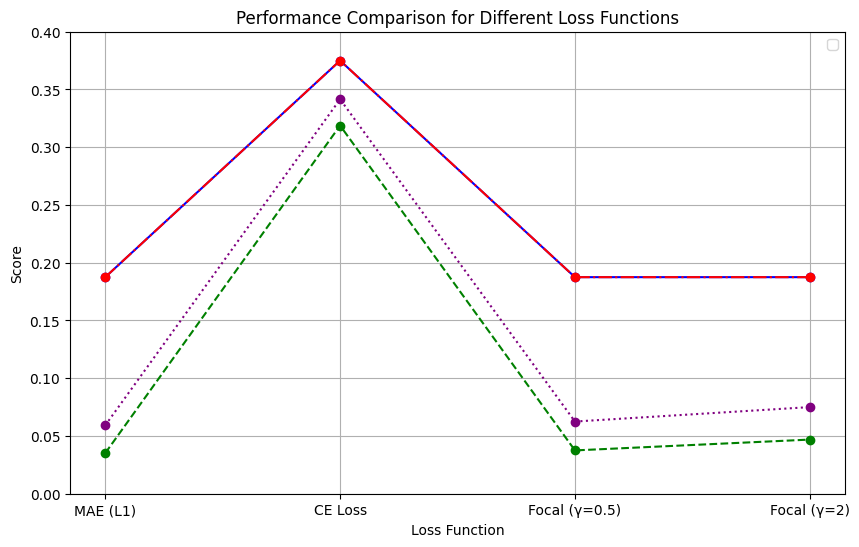

In [51]:
accuracy_ce= 0.375 
precision_ce= 0.31875
recall_ce= 0.375
f1_ce= 0.34151785714285715

accuracy_mae= 0.1875
precision_mae= 0.03515625
recall_mae= 0.1875
f1_mae= 0.05921052631578947

accuracy_focal_05= 0.1875
precision_focal_05= 0.037500000000000006
recall_focal_05= 0.1875
f1_focal_05= 0.0625

accuracy_focal_2= 0.1875
precision_focal_2= 0.046875
recall_focal_2= 0.1875
f1_focal_2= 0.07500000000000001
loss_functions = ['MAE (L1)', 'CE Loss', 'Focal (γ=0.5)', 'Focal (γ=2)']
accuracy_scores = [accuracy_mae, accuracy_ce, accuracy_focal_05, accuracy_focal_2]
precision_scores = [precision_mae, precision_ce, precision_focal_05, precision_focal_2]
recall_scores = [recall_mae, recall_ce, recall_focal_05, recall_focal_2]
f1_scores = [f1_mae, f1_ce, f1_focal_05, f1_focal_2]

# 创建图形
plt.figure(figsize=(10, 6))

# 添加标题和标签
plt.xlabel('Loss Function')
plt.ylabel('Score')
plt.title('Performance Comparison for Different Loss Functions')
plt.legend()
plt.grid(True)

plt.ylim(0, 0.4)  # 设置y轴范围在0到1之间，适应准确度的范围

plt.grid(True)  # 添加网格，可以帮助更清晰地看到数据点

plt.plot(loss_functions, accuracy_scores, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.plot(loss_functions, precision_scores, marker='o', linestyle='--', color='green', label='Precision')
plt.plot(loss_functions, recall_scores, marker='o', linestyle='-.', color='red', label='Recall')
plt.plot(loss_functions, f1_scores, marker='o', linestyle=':', color='purple', label='F1 Score')
plt.show()




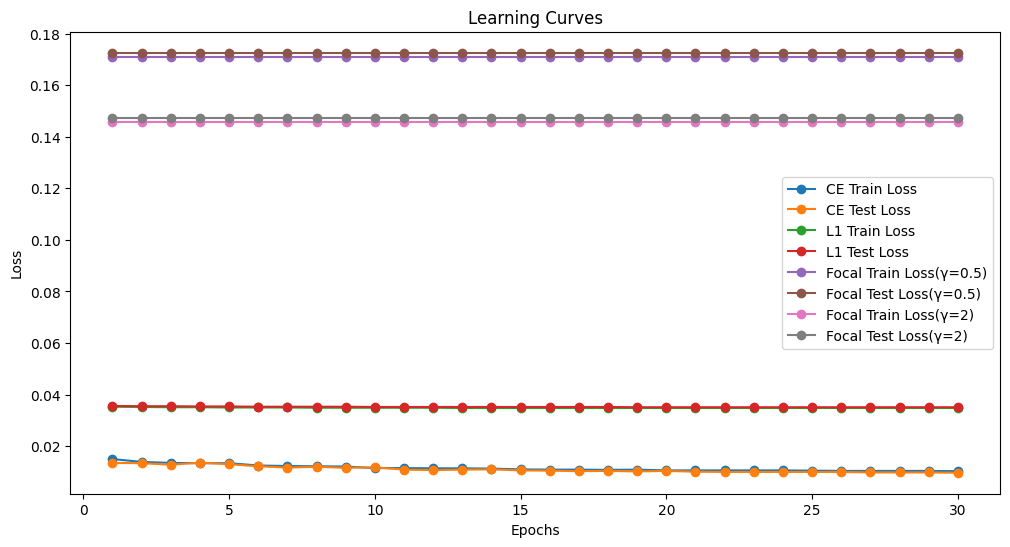

In [59]:
import matplotlib.pyplot as plt

# 假设你有一个包含epochs数量的列表
epochs = list(range(1, 31))  # 30个epochs

# 确保每个损失列表都有相同数量的数据点
ce_train_loss = [0.0150, 0.0139, 0.0135, 0.0134, 0.0134, 0.0125, 0.0123, 0.0122, 0.0121, 0.0115, 0.0115, 0.0114, 0.0114, 0.0113, 0.0110, 0.0109, 0.0109, 0.0108, 0.0109, 0.0106, 0.0106, 0.0106, 0.0106, 0.0106, 0.0105, 0.0104, 0.0104, 0.0104, 0.0104, 0.0103]
ce_test_loss = [0.0135, 0.0134, 0.0128, 0.0136, 0.0130, 0.0122, 0.0117, 0.0120, 0.0116, 0.0118, 0.0109, 0.0107, 0.0109, 0.0110, 0.0106, 0.0105, 0.0103, 0.0104, 0.0102, 0.0104, 0.0101, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0098, 0.0098, 0.0098, 0.0097]
l1_train_loss = [0.0353, 0.0352, 0.0351, 0.0351, 0.0350, 0.0350, 0.0350, 0.0349, 0.0349, 0.0349, 0.0349, 0.0349, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348, 0.0348]
l1_test_loss = [0.0356, 0.0355, 0.0355, 0.0354, 0.0354, 0.0353, 0.0353, 0.0353, 0.0353, 0.0352, 0.0352, 0.0352, 0.0352, 0.0352, 0.0352, 0.0352, 0.0352, 0.0352, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351, 0.0351]
focal5_train_loss = [0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708, 0.1708]
focal5_test_loss = [0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726, 0.1726]
focal2_train_loss = [0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459, 0.1459]
focal2_test_loss =  [0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473, 0.1473]
# 创建一个图形 
plt.figure(figsize=(12,6))

# 绘制学习曲线
plt.plot(epochs, ce_train_loss, marker='o', label='CE Train Loss')
plt.plot(epochs, ce_test_loss[:len(epochs)], marker='o', label='CE Test Loss')  # 截取相同长度的测试损失列表
plt.plot(epochs, l1_train_loss, marker='o', label='L1 Train Loss')
plt.plot(epochs, l1_test_loss[:len(epochs)], marker='o', label='L1 Test Loss')
plt.plot(epochs, focal5_train_loss, marker='o', label='Focal Train Loss(γ=0.5)')
plt.plot(epochs, focal5_test_loss[:len(epochs)], marker='o', label='Focal Test Loss(γ=0.5)')
plt.plot(epochs, focal2_train_loss, marker='o', label='Focal Train Loss(γ=2)')
plt.plot(epochs, focal2_test_loss[:len(epochs)], marker='o', label='Focal Test Loss(γ=2)')

# 添加标签和图例
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

# 显示图形
plt.show()
